## Pytorch implementation of Dynamic Memory Network Plus 

### Introduction

This tutorial shows how to implement the paper ["Dynamic Memory Network for Textual and Visual Question Answering"](https://arxiv.org/abs/1603.01417) in Pytorch and the explnation of different modules used in the same. The code has been heavily used from the repository https://github.com/dandelin/Dynamic-memory-networks-plus-Pytorch.

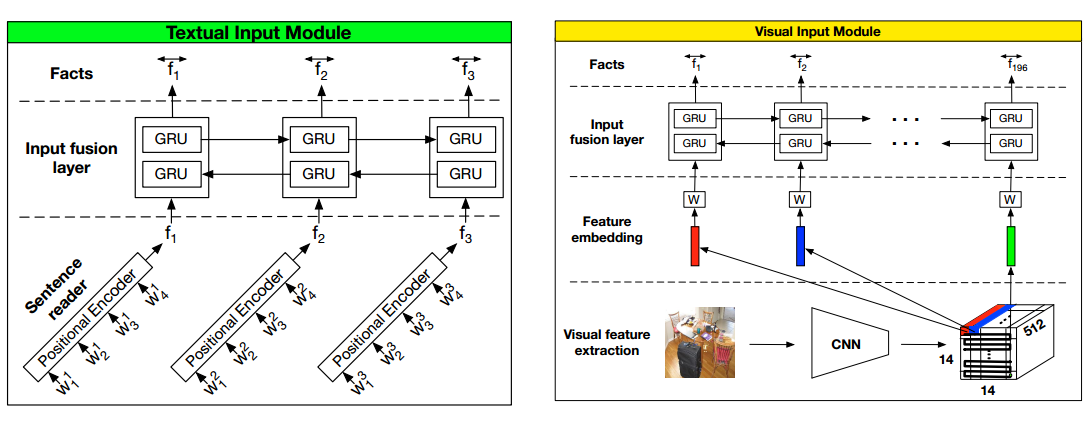

In [1]:
from IPython.display import Image, display
Image('Network.png')

Let's now implement the loader function to load our dataset and all the libraries required for implementation.


In [ ]:
''' This is dataset loader file to load the bAbI dataset. '''
import re
import numpy as np
import os
import torch
import torch.nn as nn
import torch. nn.init as init
import torch.nn.functional as F
from glob import glob
from torch.utils.data import Dataloader
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable

class adict(dict):
    def __init__(self, *args, **kargs):
        dict.__init__(self, *args, **kargs)
        self.__dict__ = self

def pad_collate(batch):
    max_len_ques = float('-inf')
    max_sen_len_context = float('-inf')
    max_len_context = float('-inf')

    for item in batch:
        contexts, ques, _ = item
        if len(contexts) > max_len_context:
            max_len_context = len(contexts)
        if len(ques) > max_len_ques:
            max_len_ques = len(ques)
        for sen in contexts:
            if(len(sen) > max_sen_len_context):
                max_sen_len_context = len(sen)
    max_len_context = min(max_len_context, 70)
    for idx, item in enumerate(batch): # Going through each example in the batch which contains their ow context, question and answer.
        context_i, question, answer = item
        context_i = context[-max_len_context:] 
        context = np.zeros((max_len_context, max_sen_len_context))
        for i, sen in enumerate(context_i): # going through ith context containing max_len_context sentences and a question
            context[i] = np.pad(sen, (0, max_sen_len_context-len(sen)), 'constant', constant_values=0)
        question = np.pad(question, (0, max_len_ques-len(question)), 'constant', constant_values=0)
        batch[idx] = (context, question, answer)

    return default_collate(batch)



In [ ]:

class BabiDataSet(Dataset):
    def __init__(self, task_id, mode='train'):
        self.mode = mode
        self.vocab_path = 'dataset/babi{}_vocab.pkl'.format(task_id)
        train_data, test_data = get_train_test(task_id) # Get raw train_data and test_data from babi dataset
        self.QA = adict()
        self.QA.VOCAB = {'<PAD>': 0, '<EOS>':1}
        self.QA.INV_VOCAB = {0:'<PAD>', 1:'<EOS>'}
        self.train = self.get_processed_data(train_data)
        self.val = [self.train[i][int(9*len(self.train[i])/10):] for i in range(3)] # splitting into 90/10 train/val dataset
        self.train = [self.train[i][:int(9*len(self.train[i])/10)] for i in range(3)] # splitting into 90/10 train/val dataset
        self.test = self.get_processed_data(test_data)

    def set_mode(self, mode):
        self.mode = mode 

    def __len__(self):
        if self.mode == 'train':
            return len(self.train[0])
        elif self.mode == 'val':
            return len(self.val[0])
        elif self.mode == 'test':
            return len(self.test[0])
        else:
            print ("Invalid Mode!")
            return

    def __getdata__(self, index):
        if self.mode == 'train':
            contexts, questions, answers = self.train
        elif self.mode == 'val':
            contexts, questions, answers = self.val
        elif self.mode == 'test':
            contexts, questions, answers = self.test

        return contexts[index], questions[index], answers[index]

    def get_processed_data(self, raw_data):
        unindexed= get_processed_data(raw_data)
        questions=[]
        contexts= []
        answers= []
        for qa in unindexed:
            context= [c.lower().split()+ ['<EOS>'] for c in qa['C']]

            for con in context:
                for token in con:
                    self.build_vocab(token)
            context= [[self.QA.VOCAB[token] for token in sentence] for sentence in context]
            question= qa['Q'].lower().split()+ ['<EOS>']

            for token in question:
                self.build_vocab(token)
            question= [self.QA.VOCAB[token] for token in question]

            self.build_vocab(qa['A'].lower())
            answer= self.QA.VOCAB[qa['A'].lower()]

            contexts.append(context)
            questions.append(question)
            answers.append(answer)
            return (contexts, questions, answers)

   



In [ ]:
def build_vocab(self, token):
    if not token in self.QA.VOCAB:
        next_index= len(self.QA.VOCAB)
        self.QA.VOCAB[token]= next_index
        self.QA.IVOCAB[next_index]= token

def get_train_test(task_id):
    paths = glob('data/en-10k/qa{}_*'.format(task_id))
    for path in paths:
        if 'train' in path;
            with open(path, 'r') as f:
                train = f.read()
        elif 'test' in path:
            with open(path, 'r') as f:
                test = f.read()

    return train, test

def build_vocab(raw_data):
    lowered= raw_data.lower()
    tokens= re.findall('[a-zA-Z]+',lowered)
    types= set(tokens)
    return types

In [ ]:
def get_unprocessed_data(raw_data):
    tasks = []
    task = None
    data = raw_data.strip().split('\n')
    for i, line in enumerate(data):
        id = int(line[0:line.find(' ')])
        if id == 1:
            task = {"C": "", "Q": "", "A": "", "S": ""}
            counter = 0
            id_map = {}

        line = line.strip()
        line = line.replace('.', ' . ')
        line = line[line.find(' ')+1:]
        # if not a question
        if line.find('?') == -1:
            task["C"] += line + '<line>'
            id_map[id] = counter
            counter += 1
        else:
            idx = line.find('?')
            tmp = line[idx+1:].split('\t')
            task["Q"] = line[:idx]
            task["A"] = tmp[1].strip()
            task["S"] = [] # Supporting facts
            for num in tmp[2].split():
                task["S"].append(id_map[int(num.strip())])
            tc = task.copy()
            tc['C'] = tc['C'].split('<line>')[:-1]
            tasks.append(tc)
    return tasks


if __name__ == '__main__':
    dataset_train= BabiDataset(20, is_train= True)
    train_loader= DataLoader(dataset_train,batch_size=2, shuffle=True,collate_fn= pad_collate)
    for batch_idx, data in enumerate(train_loader):
        contexts, questions, answers= data
        break		

This paper is a much improved version of the previous paper titled ["Dynamic Memory Networks for Natural Language Processing"](https://arxiv.org/abs/1506.07285). The main contribution of this paper is the improved InputModule for calculating the facts from input sentences keeping in mind the exchange of information between input sentences using a Bidirectional GRU and a improved version of MemoryModule using Attention based GRU model.

The network has four different types of modules namely QuestionModule, InputModule, MmemoryModule and the AnswerModule. Let's understand each of these modules in detail and their implementation.

### QuestionModule

The QuestionModule is pretty straightforward. It encodes the question of the task into a distributed vector representation. This representation is fed into the episodic memory module and forms the basis or initial state of the memory state.

In [ ]:
class QuestionModule(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(QuestionModule, self).__init__()
        self.vocab_size = vocab_size # Size of the vocabulary used in word embedding
        self.hidden_size = hidden_size # Size of the hidden state of GRU
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, questions, word_embedding):
        # questions.size() = (batch_size, num_tokens)
        # word_embedding -> (batch_size, num_tokens, embedding_length)
        # self.gru() -> (1, batch_size, hidden_size)

        questions = word_embedding(questions) # Word embedding of the question
        output, questions = self.gru(questions)
        questions = torch.transpose(questions, 0, 1)

        return questions

### InputModule 

InputModule encodes the raw text inputs into distributed vector representation. We replace the single GRU in DMN (first paper) by two different components. The first component is a sentence reader which encodes the words in a sentence into sentence encoding using a specific encoding scheme called Positional Encoder. THe output of the positional encoder are vectors represented as f1, f2, f3,... and these go as the input to the second component called as Input Fusion Layer. The main function of this layer is to allow the interaction between different input sentences to exchange information not only in the forward direction but also in the backward direction i.e., information from future states flowing backwards using a Bidirectional GRU module. Basically input fusion layer allows for distant supporting sentences to have a more direct interaction.

In [ ]:
class InputModule(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(InputModule, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True, batch_first=True)
        for name, param in self.gru.state_dict().items():
            if 'weight' in name:
                init.xavier_normal(param)
        self.dropout = nn.Dropout(0.1)

    ''' We will now define the encoding scheme which is positional encoding in the paper " Dynamic Memory Network 
    for Textual and Visual Question Answering '''
    def positional_encoder(embedded_sentence):
        # embedded_sentence.size() = (batch_size, num_sentences, num_tokens, embedding_length)
        # l.size() = (num_tokems, embedding_length)
        # output.size() = (num_batch, num_sentences, embedding_length)
        # The outputs are basically f1, f2, f3,.... which will go into the input fusion layer in the next step to 
        # add share information between sentences using a BiDirfectional GRU module.

        batch_size, num_sentences, num_tokens, embedding_length = embedded_sentence.size()
        l = [] # It will be same for all sentences in all batches as num_tokens and embedding_length is same 
        # for the entire dataset.
        for j in range(num_tokens):
            x = []
            for d in range(embedding_length):
                x.append((1 - (j/(num_tokens-1))) - (d/(embedding_length-1)) * (1 - 2*j/(num_tokens-1)))
            l.append(x)

        l = torch.FloatTensor(l)
        l = l.unsqueeze(0) # adding an extra dimension at first place for batch_size
        l = l.unsqueeze(1) # adding an extra dimension at sencond place for num_sentences
        l = l.expand_as(embedded_sentence) # so that l.size() = (batch_size, num_sentences, num_tokens, embedding_length)

        mat = embedded_sentence*Variable(l.cuda())
        f_ids = torch.sum(mat, dim=2).squeeze(2) # sum along token dimension

        return f_ids


    def forward(self, input, word_embedding):
        # input.size() = (batch_size, num_sentences, num_tokens)
        # word_embedding -> (batch_size, num_sentences, num_tokens, embedding_length)
        # positional_encoder(word_embedding(input)) -> (batch_size, num_sentences, embedding_length)
        # Now BidirectionalGRU blocks receive their input, the output of the positional encoder and finally give facts
        # facts.size() = (batch_size, num_sentences, embedding_length) embedding_length = hidden_size

        input = input.view(input.size()[0], -1)
        input = word_embedding(input)
        input = input.view(input.size()[0], input.size()[1], input.size()[2], -1)
        input = self.positional_encoder(input)
        input = self.dropout(input)

        h0 = Variable(torch.zeros(2, input.size()[0], self.hidden_size).cuda()) # Initializing the initial hidden state (at t=0 time step)
        facts, hdn = self.gru(input, h0)
        facts = facts[:, :, :hidden_size] + facts[:, :, hidden_size:]

        return facts


### MemoryModule

MemoryModule has two separate components, Attention mechanism which gives a contextual vector c(t) which is basically a summary of relevant input for the t_th pass considering question (q) and the previous memory state m(t-1) and the second one is the memory update mechanism which outputs m(t) using c(t) and m(t-1)

#### AttentionGRUCell

Attention based GRU is a modification of the original GRU by embedding information from the attention mechanism. In the GRU module, the update gate decides how much of each dimension of the hidden state to retain and how much to update depending upon the input(xi). Since update gate (ui) is calculated using only input(xi) and previous hidden state(hi_1), it certainly lacks any sort of knowledge from the question or the previous memory state. We can use these two to update the hidden state by replacing ui in GRU equation with the gate value(gi_t).

In [ ]:
class AttnGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttnGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.Wr = nn.Linear(input_size, hidden_size)
        self.Ur = nn.Linear(hidden_size, hidden_size)
        self.W = nn.Linear(input_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)

        init.xavier_normal(self.Wr.state_dict()['weight'])
        init.xavier_normal(self.Ur.state_dict()['weight'])
        init.xavier_normal(self.W.state_dict()['weight'])
        init.xavier_normal(self.U.state_dict()['weight'])

    def forward(self, fact, hi_1, g):
        # fact is the final output of InputModule for each sentence and fact.size() = (batch_size, embedding_length)
        # hi_1.size() = (batch_size, embedding_length=hidden_size)
        # g.size() = (batch_size, )

        r_i = F.sigmoid(self.Wr(fact) + self.Ur(hi_1))
        h_tilda = F.tanh(self.W(fact) + r*self.U(hi_1))
        hi = g*h_tilda + (1 - g)*hi_1

        return hi # Returning the next hidden state considering the first fact and so on.

#### AttentionGRU

This class basically update the hidden state using Attention based GRU defined above by iterating over all the sentences. Final hidden state is called the contextual vector which is used to update next memory state.

In [ ]:
class AttnGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AttnGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.AttnGRUCell = AttnGRUCell(input_size, hidden_size)

    def forward(self, facts, G):
        # facts.size() = (batch_size, num_sentences, embedding_length)
        # fact.size() = (batch_size, embedding_length=hidden_size)
        # G.size() = (batch_size, num_sentences)
        # g.size() = (batch_size, )

        h_0 = Variable(torch.zeros(self.hidden_size)).cuda()

        for sen in range(facts.size()[1]):
            fact = facts[:, sen, :]
            g = G[:, sen]
            if sen == 0: # Initialization for first sentence only 
                hi_1 = h_0.unsqueeze(0).expand_as(fact)
            hi_1 = self.AttnGRUCell(fact, hi_1, g)
        C = hi_1 # Final hidden vector as the contextual vector used for updating memory

        return C

#### EpisodicMemoryModule

The episodic memory module retrieves information from the final input facts by focusing attention on a subset of these facts using gate values. We implement this attention by associating a single scalar value, the attention gate (gi_t) with each fact during each pass. This is calculated by allowing interaction between the fact and both the question and the previous memory state. Once we have the attention gate, we can use an attention mechanism to extract a contextual vector ct which is used to update the memory state.

In [ ]:
class MemoryModule(nn.Module): # Takes facts, question and prev_mem as its and output next_mem
    def __init__(self, hidden_size):
        super(MemoryModule, self).__init__()
        self.hidden_size = hidden_size
        self.AttnGRU = AttnGRU(hidden_size, hidden_size)
        self.W1 = nn.Linear(4*hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, 1)
        self.W_mem = nn.Linear(3*hidden_size, hidden_size)

        init.xavier_normal(self.W1.state_dict()['weight'])
        init.xavier_normal(self.W2.state_dict()['weight'])
        init.xavier_normal(self.W_mem.state_dict()['weight'])

    def gateMatrix(self, facts, questions, prev_mem):
        # facts.size() = (batch_size, num_sentences, embedding_length=hidden_size)
        # questions.size() = (batch_size, 1, embedding_length)
        # prev_mem.size() = (batch_size, 1, embedding_length)
        # z.size() = (batch_size, num_sentences, 4*embedding_length)
        # G.size() = (batch_size, num_sentences)

        questions = questions.expand_as(facts)
        prev_mem = prev_mem.expand_as(facts)

        z = torch.cat([facts*questions, facts*prev_mem, torch.abs(facts - questions), torch.abs(facts - prev_mem)], dim=2)
        # z.size() = (batch_size, num_sentences, 4*embedding_length)
        z = z.view(-1, 4*embedding_length)
        Z = self.W2(F.tanh(self.W1(z)))
        Z = Z.view(batch_size, -1)
        G = F.softmax(Z)

        return G

    def forward(self, facts, questions, prev_mem):
        # questions = questions.unsqueeze(1)
        # prev_mem = prev_mem.unsqueeze(1)
        G = self.gateMatrix(facts, questions, prev_mem)
        C = self.AttnGRU(facts, G)
        # Now considering prev_mem, C and question, we will update the memory state as follows
        concat = torch.cat([prev_mem.squeeze(1), C, questions.squeeze(1)], dim=1)
        next_mem = F.relu(self.W_mem(concat))
        next_mem = next_mem.unsqueeze(1)

        return next_mem

### AnswerModule

The answer module takes in input both the question as well as final memory hidden state to update the the answer. Here we concatenate the final memory state and the question qnd then we can pass it through a linear layer.

In [ ]:
class AnswerModule(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(AnswerModule, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.W = nn.Linear(2*hidden_size, vocab_size)
        init.xavier_normal(self.W.state_dict()['weight'])
        self.dropout = nn.Dropout(0.1)

    def forward(self, final_mem, questions):
        final_mem = self.dropout(final_mem)
        concat = torch.cat([final_mem, questions], dim=2).squeeze(1)
        out = self.W(concat) # As per the paper, we are concatenating the final memory state m_T, and the question q and passing 
        # this resultant vector to a linear layer

        return out

We define the model for the network incorporating the input, question, answer and the episodic memory module. We use the Cross Entropy loss criterion for measuring loss. Vocab size refers to the size of vocabulary used. The output from the input module, question module are used and the representations of memory module are calculated for a fixed number of passes. Predictions are then made using that final representation of memory module and the output from the question module.

In [ ]:
''' We define the model for the network incorporating the input, question, answer and the episodic memory module. We use the Cross Entropy loss criterion for measuring loss'''    
class DMN(nn.Module):
    def __init__(self, hidden_size, vocab_size, num_pass=3, qa=None):
        super(DMN,self).__init__()
        self.num_pass= num_pass
        self.qa= qa
        self.word_embedding= nn.Embedding(vocab_size, hidden_size, padding_index=0, sparse=True)
        init.uniform(self.word_embedding.state_dict()['weight'], a= -(3**0.5), b=3**0.5)
        self.criterion= nn.CrossEntropyLoss(size_average=False)
        
        self.input_module= input_module(vocab_size,hidden_size)   ##Vocab size refers to the size of vocabulary used
        self.question_module= question_module(vocab_size, hidden_size) 
        self.memory= episodic_memory(hidden_size)
        self.answer_module= answer_module(vocab_size,hidden_size)
        
    def forward(self, context, questions):
        #facts.size()= (batch_size, num_sentences, embedding_length= hidden.size()) 
        #questions.size() = (batch_size, 1, embedding_length)
        facts= self.input_module(context, self.word_embedding)
        questions= self.question_module(questions, self.word_embedding)
        X= questions
        for passes in range(self.num_pass):
            X= self.memory(facts, questions, X)
        pred= self.answer_module(X, questions)
        return pred_id
    
    '''Total loss to be calculated '''
    
    def loss(self,context, questions, targets):
        output= self.forward(context, questions)
        loss= self.criterion(output, targets)
        para_loss= 0
        for param in self.parameters():
            para_loss+= 0.001* torch.sum(param*param)
        pred= F.softmax(output)
        _, pred_id= torch.max(pred, dim=1)
        correct= (pred_id.data == answers.data)
        acc= torch.mean(correct.float())   
        return loss+para_loss, acc
    
    def interpret_indexed_tensor(self,var):
        if len(var.size()) == 3:
            for n, sentences in enumerate(var):
                s= ' '.join([self.qa.IVOCAB[elem.data[0]] for elem in sentence])
                print (str(n)+'th batch, '+str(i)+'th sentence, '+str(s))
                
        elif len(var.size()) == 2:
            for n, sentence in enumerate(var):
                s= ' '.join([self.qa.IVOCAB[elem.data[0]] for elem in sentence])
                print (str(n)+'th batch, '+str(s))
                
        elif len(var.size()) == 1:
            for n, token in enumerate(var):
                s= self.qa.IVOCAB[token.data[0]]
                print (str(n)+'th of batch, '+str(s))
        

We now train, validate and test the network on the BABI dataset provided by facebook. Training is done for 256 epochs and we use Adam optimizer for training. Early stopping criterion is employed for training.

In [ ]:


if __name__ == '__main__':
    for itr in range(10):
        for task in range(1,21):
            dataset= BabiDataset(task)
            vocab_size= len(dataset.QA.VOCAB)
            hidden_size= 80
            
            model= DMN(hidden_size, vocab_size, num_pass= 3, qa= dataset.QA)   ##vocab_size denotes the size of word embedding used 
            early_stop_count= 0
            early_stop_flag= False
            best_acc= 0
            optim= torch.optim.Adam(model.parameters())
            
            for epoch in range(256):
                dataset.set_mode('train')
                train_load= DataLoader(dataset, batch_size=100, shuffle= True, collate_fn= pad_collate)  ### Loading the babi dataset
                
                model.train()                                                       ### training the network
                if not early_stop_flag:
                    total_acc=0
                    count= 0
                    for batch_id, data in enumerate(train_load):
                        optim.zero_grad()
                        context, questions, answers = data
                        batch_size= context.size()[0]
                        context= Variable(context.long())                           ## context.size() = (batch_size, num_sentences, embedding_length) embedding_length = hidden_size 
                        questions= Variable(questions.long())                       ## questions.size() = (batch_size, num_tokens)
                        answers= Variable(answers)
                        
                        total_loss, acc= model.loss(context,questions,answers)      ## Loss is calculated and gradients are backpropagated through the layers.
                        total_loss.backward()
                        total_acc+= acc*batch_size
                        count+= batch_size
                        
                        if batch_id %20 == 0:
                            print('training error')
                            print ('task '+str(task_id)+',epoch '+str(epoch)+',loss ' +str(loss.data[0])+',total accuracy : '+str(total_acc/cnt))
                        optim.step()
                    
                    '''Validation part'''


                    dataset.set_mode('valid')
                    valid_load = DataLoader(dataset, batch_size= 100, shuffle= False, collate_fn= pad_collate)    ## Loading the validation data
                    
                    model.eval()
                    total_acc=0
                    count=0
                    for batch_id, data in enumerate(train_load):
                        context, questions, answers = data
                        batch_size= context.size()[0]
                        context= Variable(context.long())
                        questions= Variable(questions.long())
                        answers= Variable(answers)
                        
                        _, acc= model.loss(context,questions,answers)  
                        total_loss.backward()
                        total_acc+= acc*batch_size
                        count+= batch_size
                    
                    total_acc= total_acc/ count
                    
                    if total_acc > best_acc:
                        best_acc= total_acc
                        best_state= model.state_dict()
                        early_stop_count= 0
                    else:
                        early_stop_count+= 1                   
                        if early_stop_count > 20:
                            early_Stop_flag= True
                    
                    print ('itr '+str(itr)+',task_id '+str(task_id)+',epoch '+str(epoch)+',total_acc '+str(total_acc))
                    
                    with open('log.txt', 'a') as fp:
                        fp.write('itr '+str(itr)+', task_id '+str(task_id)+',epoch '+str(epoch)+',total_acc '+str(total_acc)+'+\n ')
                    if total_acc == 1.0:
                        break
                else:
                    print('iteration'+str(itr)+'task' +str(task_id)+' Early Stopping at Epoch'  +str(epoch)+'validation accuracy :' +str(best_acc))
                    
            
            
            dataset.set_mode('test')
            test_load= DataLoader(dataset, batch_size=100, shuffle= False, collate_fn= pad_collate)
            
            test_acc= 0
            count=0
            
            for batch_id, data in enumerate(test_load):
                    context, questions, answers = data
                    batch_size= context.size()[0]
                    context= Variable(context.long())
                    questions= Variable(questions.long())
                    answers= Variable(answers)
                    
                    model.load_state_dict(best_state)
                    _, acc= model.loss(context, questions, answers)
                    
                    test_acc += acc* batch_size 
                    count += batch_size
                    print ('itr '+ str(itr)+'task =' +str(task_id)+ 'Epoch ' +str(epoch)+' test accuracy : '+str(test_acc / count))
                    
                    
                    
                    os.makedirs('models',exist_ok= True)
                    with open('models/task'+str(task_id)+'_epoch'+str(epoch)+'_run'+str(run)+'_acc'+str(test_acc/cnt)+'.pth', 'wb') as fp:
                        torch.save(model.state_dict(), fp)
                    with open('log.txt', 'a') as fp:
                        fp.write('[itr '+str(itr)+', Task '+str(task_id)+', Epoch '+str(epoch)+'] [Test] Accuracy : '+str(total_acc)+' + \n')

                        

### Conclusion

We just saw the implementation of DMNPlus for bAbI dataset for 20 different types of task and got a pretty good result. This model can be easily extended for visual question answering as well. Only the input module differs in case of VQA. In this, the module splits the original image into small local regions and considers each region equivalent to a sentence in the input module for text. We use CNN to extract features from each of the small local regions and the final output layer is divided into a number of local regional vectors equivalant to f1, f2, f3,...in case of text. Further process is exactly same as that of textual question answering.

Unlike the previous paper on DMN, this model answers question without providing supporting facts for answering the question. Also DMNPlus can be extended to other modalities such as images for VQA. In future, We will train the model on SQuAD dataset. 